In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from adjustText import adjust_text
import numpy as np

import nfl_data_py as nfl

intra-team efficiency with WR1 and WR2 on the field - i.e. the team does X good with AJ Brown on the field and Y good with both AJ Brown and Devonta Smith on the field

inter-team efficiency - teams with two WRs in the top x% versus teams with only one WR in the top x%

In [2]:
# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)


In [3]:
years = range(2016, 2023)

In [4]:
data = nfl.import_pbp_data(years, cache=True, alt_path="../cache")

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


delta epa/target of WR1 on the field versus WR1 and WR2 on the field over time

In [22]:
# Keep only the columns we need
df = data[['season', 'posteam', 'receiver', 'receiver_id', 'season_type', 'play_type', 'complete_pass', 'epa']]

In [238]:
# Keep only pass plays and regular season
df = df[(df['play_type'] == 'pass') & (df['season_type'] == 'REG')]

In [267]:
# Get the number of targets for each receiver, average epa per target
wr = df.groupby(['season', 'posteam', 'receiver', 'receiver_id'])\
            .agg({'complete_pass': 'count', 'epa': 'mean'}).reset_index()\
                .rename(columns={'complete_pass': 'targets', 'epa': 'epa_per_target'})

In [268]:
# Get WR1 or WR2 designation
wr.sort_values(by=['season', 'posteam', 'targets'], ascending=[True, True, False], inplace=True)

wr['rank'] = wr.groupby(['season', 'posteam']).cumcount() + 1

def classify_wr(rank):
    if rank == 1:
        return 'WR1'
    elif rank == 2:
        return 'WR2'
    else:
        return 'neither'

wr['classification'] = wr['rank'].apply(classify_wr)

wr.drop(columns=['rank'], inplace=True)

In [269]:
# Define function to calculate delta
def calculate_delta_targets(group):
    wr1_targets = group[group['classification'] == 'WR1']['targets']
    wr2_targets = group[group['classification'] == 'WR2']['targets']
    if len(wr1_targets) > 0 and len(wr2_targets) > 0:
        return wr1_targets.values[0] - wr2_targets.values[0]
    else:
        return None  # or any other value you want to assign when there's no WR1 or WR2


# Calculate delta targets for each ['season', 'posteam'] group and store in a new DataFrame
delta_targets_df = wr.groupby(['season', 'posteam']).apply(
    calculate_delta_targets).reset_index().rename(columns={0: 'delta_targets'})

# Merge this DataFrame with the original one
wr = pd.merge(wr, delta_targets_df, on=['season', 'posteam'], how='left')


In [270]:
# Split into WR1 and WR2
wr1 = wr[wr['classification'] == 'WR1']
wr2 = wr[wr['classification'] == 'WR2']

In [271]:
# Get a dataframe of plays
plays = data[['game_id', 'play_id', 'season', 'posteam', 'receiver', 'receiver_id', 'season_type', 'play_type', 'complete_pass', 'epa', 'offense_players']]

In [272]:
plays = plays[(plays['play_type'] == 'pass') & (plays['season_type'] == 'REG')]

In [273]:
# Keep only the plays where the receiver is WR1
wr1_plays = plays.merge(wr1[['season', 'posteam', 'receiver', 'receiver_id', 'classification', 'delta_targets']], how='inner', on=['season', 'posteam', 'receiver', 'receiver_id'])

In [274]:
def wr2_on_field(row, wr2):
    season = row['season']
    posteam = row['posteam']

    # Check if offense_players is None
    if row['offense_players'] is None:
        return False

    offense_players = set(row['offense_players'].split(';'))

    # Get WR2 for the specific season and team
    wr2_player = wr2[(wr2['season'] == season) & (wr2['posteam'] == posteam)]

    if not wr2_player.empty:
        wr2_id = wr2_player['receiver_id'].values[0]
        return wr2_id in offense_players

    return False


# Add the new column to the wr1_plays DataFrame
wr1_plays['wr2_on_field'] = wr1_plays.apply(wr2_on_field, axis=1, args=(wr2,))


In [275]:
# Separate the dataframe into two: where WR2 is on field and where WR2 is not
wr1_with_wr2 = wr1_plays[wr1_plays['wr2_on_field'] == True]
wr1_without_wr2 = wr1_plays[wr1_plays['wr2_on_field'] == False]

# Calculate the mean 'epa' per season, posteam, receiver and receiver_id where WR2 is on field
mean_epa_with_wr2 = wr1_with_wr2.groupby(['season', 'posteam', 'receiver', 'receiver_id']).agg({'epa': 'mean', 'delta_targets': 'last'}).reset_index()
mean_epa_with_wr2.rename(columns={'epa': 'epa_with_wr2'}, inplace=True)

# Calculate the mean 'epa' per season, posteam, receiver and receiver_id where WR2 is not on field
mean_epa_without_wr2 = wr1_without_wr2.groupby(['season', 'posteam', 'receiver', 'receiver_id']).agg({'epa': 'mean', 'delta_targets': 'last'}).reset_index()
mean_epa_without_wr2.rename(columns={'epa': 'epa_without_wr2'}, inplace=True)

# Merge the two dataframes on season, posteam, receiver and receiver_id
summary_df = pd.merge(mean_epa_with_wr2, mean_epa_without_wr2, on=['season', 'posteam', 'receiver', 'receiver_id', 'delta_targets'], how='outer')


In [276]:
# Drop NaN values
summary_df = summary_df.dropna()

In [277]:
summary_df

,season,posteam,receiver,receiver_id,epa_with_wr2,delta_targets,epa_without_wr2
0,2016,ARI,L.Fitzgerald,00-0022921,0.233650,29,0.062322
1,2016,ATL,J.Jones,00-0027944,0.420228,48,0.697985
2,2016,BAL,D.Pitta,00-0027714,-0.199967,5,0.270009
3,2016,BUF,C.Clay,00-0028112,0.338443,11,-0.053940
4,2016,CAR,G.Olsen,00-0025418,0.246835,14,-0.036735
...,...,...,...,...,...,...,...
214,2022,SEA,D.Metcalf,00-0035640,0.133889,25,-0.464289
215,2022,SF,B.Aiyuk,00-0036261,0.263693,20,0.585326
216,2022,TB,C.Godwin,00-0033921,0.232471,17,-0.011873
217,2022,TEN,R.Woods,00-0030431,0.116015,31,0.068641


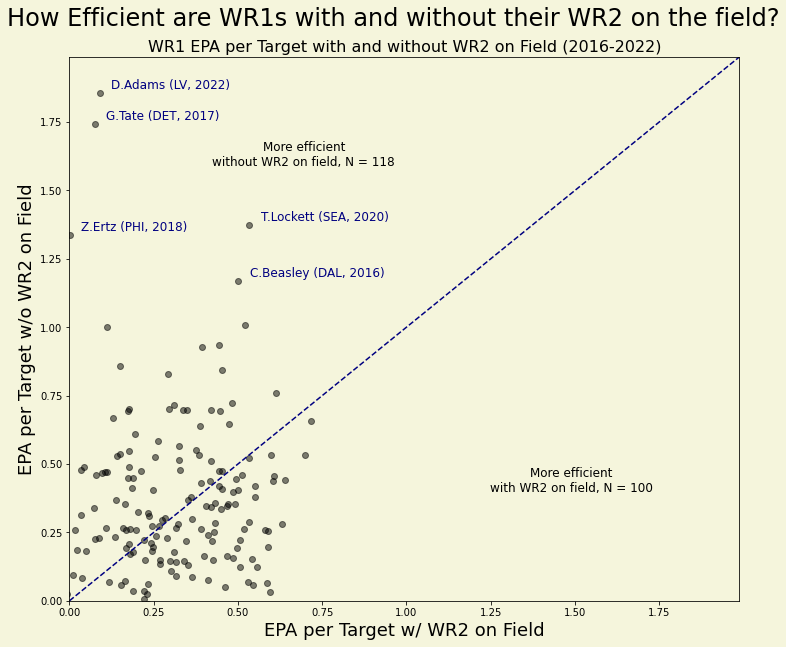

In [365]:
from adjustText import adjust_text
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12, 10))

# Change the background color to beige
fig.patch.set_facecolor('beige')
ax.set_facecolor('beige')

# Create the scatter plot with dynamic point sizing relative to max delta_targets
scatter = ax.scatter(summary_df['epa_with_wr2'], summary_df['epa_without_wr2'],
                
                     alpha=0.5, color='black')

# Add a line that separates where receivers are better or worse with their WR2 on vs off the field
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='navy', linestyle='--')

# Set title and labels for axes
plt.suptitle('How Efficient are WR1s with and without their WR2 on the field?',
             fontsize=24, y=0.95, ha='center')
plt.title("WR1 EPA per Target with and without WR2 on Field (2016-2022)",
          fontsize=16, y=1.0, ha='center')
plt.xlabel('EPA per Target w/ WR2 on Field', fontsize=18)
plt.ylabel('EPA per Target w/o WR2 on Field', fontsize=18)

# Make x and y axis scales equivalent
plt.xlim(0, max(ax.get_xlim()[1], ax.get_ylim()[1]))
plt.ylim(0, max(ax.get_xlim()[1], ax.get_ylim()[1]))

#Annotate points which are significantly better with or without their WR2
texts = []
count_more_efficient = 0
count_less_efficient = 0
for i, row in summary_df.iterrows():
    if row['epa_without_wr2'] > row['epa_with_wr2']:
        count_less_efficient += 1
    else:
        count_more_efficient += 1
    if row['epa_without_wr2'] > 1.15:
        texts.append(ax.annotate(
            f"{row['receiver']} ({row['posteam']}, {row['season']})",
            (row['epa_with_wr2'], row['epa_without_wr2']),
            fontsize=12, color='navy'
        ))

# Add labels indicating where receivers are more efficient
plt.text(0.35, 0.8, "More efficient\nwithout WR2 on field, N = " + str(count_more_efficient),
         transform=ax.transAxes, fontdict={'size': 12, 'ha': 'center'})
plt.text(0.75, 0.2, "More efficient\nwith WR2 on field, N = " + str(count_less_efficient),
         transform=ax.transAxes, fontdict={'size': 12, 'ha': 'center'})

# Add legend for dynamic point sizing
# Using a couple of example sizes for the legend.
# Adjust the sizes and labels as appropriate for your data.
legend_elements = [mpatches.Circle((0, 0), radius=10, color='black', alpha=0.5, label='Large difference in targets'),
                   mpatches.Circle((0, 0), radius=5, color='black', alpha=0.5, label='Small difference in targets')]

# Adjust the position of non-overlapping annotations
if texts:
    adjust_text(texts, expand_points=(1.2, 1.2))

plt.savefig('../images/scatterplot_epa_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [326]:
dropbacks= data[['season', 'posteam', 'season_type', 'qb_dropback', 'epa']]

In [327]:
dropbacks = dropbacks[(dropbacks['qb_dropback'] == 1.0) & (dropbacks['season_type'] == 'REG')]

In [328]:
dropbacks = dropbacks.groupby(['season', 'posteam']).agg({'epa': 'mean'}).reset_index()

In [329]:
# Get the top 10 WR2s by target per year
top_wr2s = wr2.groupby(['season', 'posteam', 'receiver', 'receiver_id']).agg({'targets': 'sum'}).reset_index()

top_wr2s = top_wr2s.sort_values(['season', 'targets'], ascending=[True, False])

top_wr2s = top_wr2s.groupby('season').head(5)

In [330]:
top_wr2s['top_WR2'] = True

In [331]:
df = pd.merge(dropbacks, top_wr2s[['season', 'posteam', 'top_WR2']], on=['season', 'posteam'], how='left')

In [332]:
df['top_WR2'].fillna(False, inplace=True)


In [333]:
result = df.groupby(['season', 'top_WR2'])['epa'].mean().reset_index()


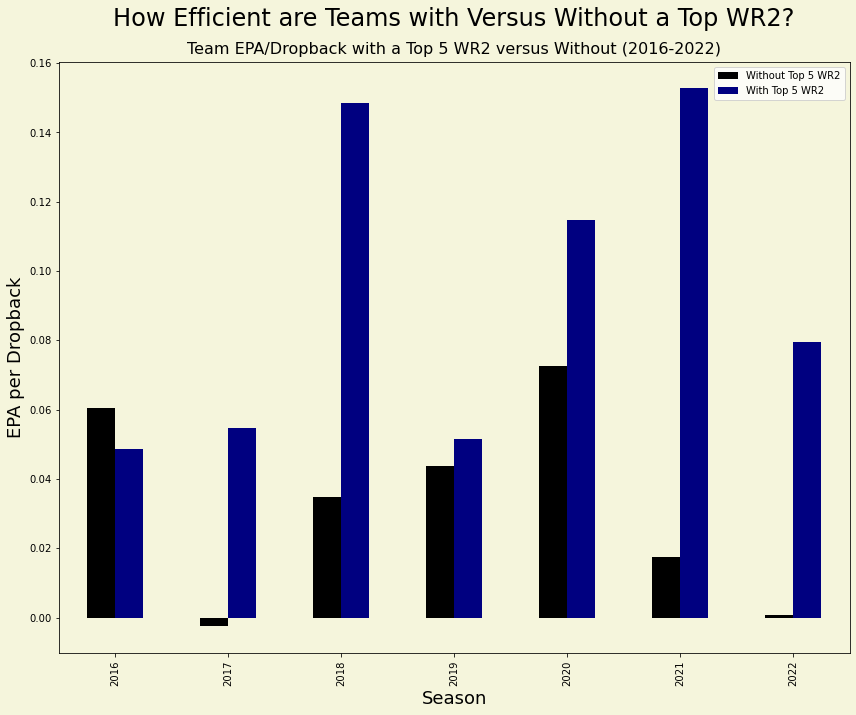

In [366]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))

# Change the background color to beige
fig.patch.set_facecolor('beige')
ax.set_facecolor('beige')

# Create pivot table and plot
pivot_table = result.pivot(index='season', columns='top_WR2', values='epa')
pivot_table.plot(kind='bar', ax=ax, color=['black', 'navy'])

# Set title and labels for axes
ax.set_title('How Efficient are Teams with Versus Without a Top WR2?',
             fontsize=24, y=1.05, ha='center')
ax.set_xlabel('Season', fontsize=18)
ax.set_ylabel('EPA per Dropback', fontsize=18)

# Add a subtitle
subtitle = "Team EPA/Dropback with a Top 5 WR2 versus Without (2016-2022)"
plt.text(0.5, 1.02, subtitle, ha='center', va='center',
         transform=ax.transAxes, fontsize=16)

# Add a legend
ax.legend(['Without Top 5 WR2', 'With Top 5 WR2'])

fig.tight_layout()
plt.savefig('../images/bar_chart_epa_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()


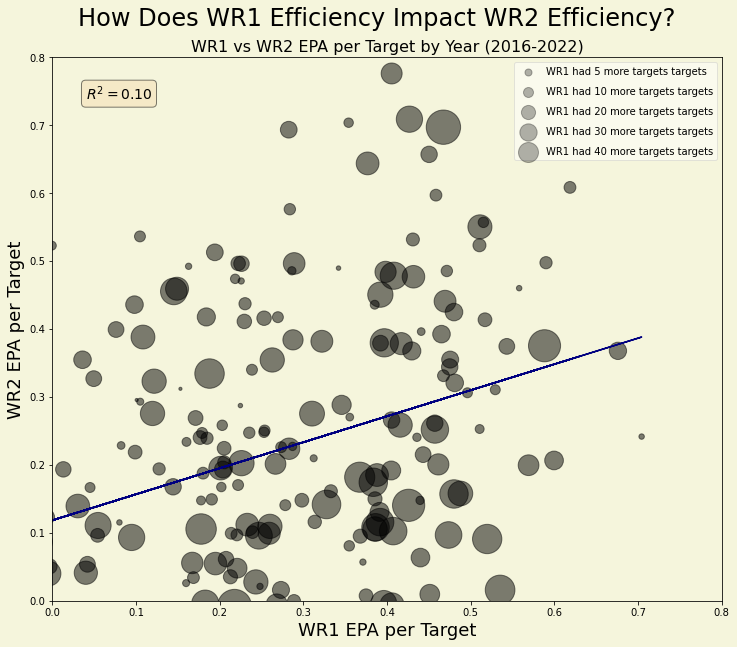

In [364]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress


# Merge the two dataframes on the 'season' and 'posteam' columns
merged_df = wr1.merge(
    wr2, on=['season', 'posteam'], suffixes=('_wr1', '_wr2'))

fig, ax = plt.subplots(figsize=(12, 10))

# Change the background color to beige
fig.patch.set_facecolor('beige')
ax.set_facecolor('beige')

# Create the scatter plot with dynamic point sizing relative to delta_targets
scatter = ax.scatter(merged_df['epa_per_target_wr1'], merged_df['epa_per_target_wr2'],
                     s=merged_df['delta_targets_wr1']*10,
                     alpha=0.5, color='black')

# Compute the trendline
z = np.polyfit(merged_df['epa_per_target_wr1'],
               merged_df['epa_per_target_wr2'], 1)
p = np.poly1d(z)

# Add the trendline
plt.plot(merged_df['epa_per_target_wr1'], p(
    merged_df['epa_per_target_wr1']), color='navy')

# Compute the R-squared value
slope, intercept, r_value, p_value, std_err = linregress(
    merged_df['epa_per_target_wr1'], merged_df['epa_per_target_wr2'])

# Add a text box with the R-squared value
textstr = f'$R^2={r_value**2:.2f}$'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Set title and labels for axes
plt.suptitle('How Does WR1 Efficiency Impact WR2 Efficiency?',
             fontsize=24, y=0.95, ha='center')
plt.title("WR1 vs WR2 EPA per Target by Year (2016-2022)",
          fontsize=16, y=1.0, ha='center')
plt.xlabel('WR1 EPA per Target', fontsize=18)
plt.ylabel('WR2 EPA per Target', fontsize=18)

# Adjust the maximum values of both axes
plt.xlim(0, 0.8)
plt.ylim(0, 0.8)

# Add legend for bubble sizes
for size in [5, 10, 20, 30, 40]:
    plt.scatter([], [], c='black', alpha=0.3, s=size*10,
                label='WR1 had ' + str(size) + ' more targets targets')
plt.legend(scatterpoints=1, frameon=True, framealpha=0.5,
           labelspacing=1, loc='upper right')

plt.savefig('../images/scatterplot_epa_comparison_wr1_wr2.png',
            dpi=300, bbox_inches='tight')
plt.show()
